In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
import itertools
from sklearn.metrics import mean_absolute_error #accuracy metrics

### Data Source

https://fred.stlouisfed.org/series/IR3TTS01CNM156N    
https://www.cbirc.gov.cn/cn/view/pages/index/guozhai.html


### Data Extraction

In [108]:
df_2020=pd.read_excel("data/国债及其他债券收益率曲线2020年01月01日—2020年12月31日.xlsx")
df_2021=pd.read_excel("data/国债及其他债券收益率曲线2021年01月01日—2021年12月31日.xlsx")
df_2022=pd.read_excel("data/国债及其他债券收益率曲线2022年01月01日—2022年12月31日.xlsx")
df_2023=pd.read_excel("data/国债及其他债券收益率曲线2023年01月01日—2023年12月31日.xlsx")
df_2024=pd.read_excel("data/国债及其他债券收益率曲线2024年01月01日—2024年12月31日.xlsx")
combined_df=pd.concat([df_2020,df_2021,df_2022,df_2023,df_2024])
combined_df["日期"]=pd.to_datetime(combined_df["日期"])
combined_df=combined_df.set_index("日期").sort_index(ascending=True)
combined_df.drop(['曲线名称'],inplace=True,axis=1)
combined_df.info()
combined_df.describe()

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1250 entries, 2020-01-02 to 2024-12-31
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3月      1250 non-null   float64
 1   6月      1250 non-null   float64
 2   1年      1250 non-null   float64
 3   3年      1250 non-null   float64
 4   5年      1250 non-null   float64
 5   7年      1250 non-null   float64
 6   10年     1250 non-null   float64
 7   30年     1250 non-null   float64
dtypes: float64(8)
memory usage: 87.9 KB


,3月,6月,1年,3年,5年,7年,10年,30年
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,1.835949,1.958868,2.048329,2.355468,2.528694,2.714073,2.735401,3.187588
std,0.367544,0.376492,0.390582,0.398307,0.371617,0.356820,0.325545,0.462770
min,0.781900,0.929600,0.930700,1.085000,1.372700,1.588700,1.675200,1.912100
25%,1.581625,1.694025,1.787200,2.224000,2.395675,2.592125,2.612700,2.973525
50%,1.840550,2.009700,2.100300,2.401700,2.574400,2.782500,2.785250,3.276450
75%,2.054125,2.194875,2.301350,2.587700,2.739950,2.902950,2.915050,3.510550
max,2.927900,3.022600,2.969000,3.120100,3.214500,3.358900,3.348700,3.941200


In [109]:
# Find the indexes that are missing
pd.date_range(start = combined_df.index.min(), end = combined_df.index.max(), freq='D').difference(combined_df.index)

DatetimeIndex(['2020-01-04', '2020-01-05', '2020-01-11', '2020-01-12',
               '2020-01-18', '2020-01-24', '2020-01-25', '2020-01-26',
               '2020-01-27', '2020-01-28',
               ...
               '2024-11-30', '2024-12-01', '2024-12-07', '2024-12-08',
               '2024-12-14', '2024-12-15', '2024-12-21', '2024-12-22',
               '2024-12-28', '2024-12-29'],
              dtype='datetime64[ns]', length=576, freq=None)

<Axes: >

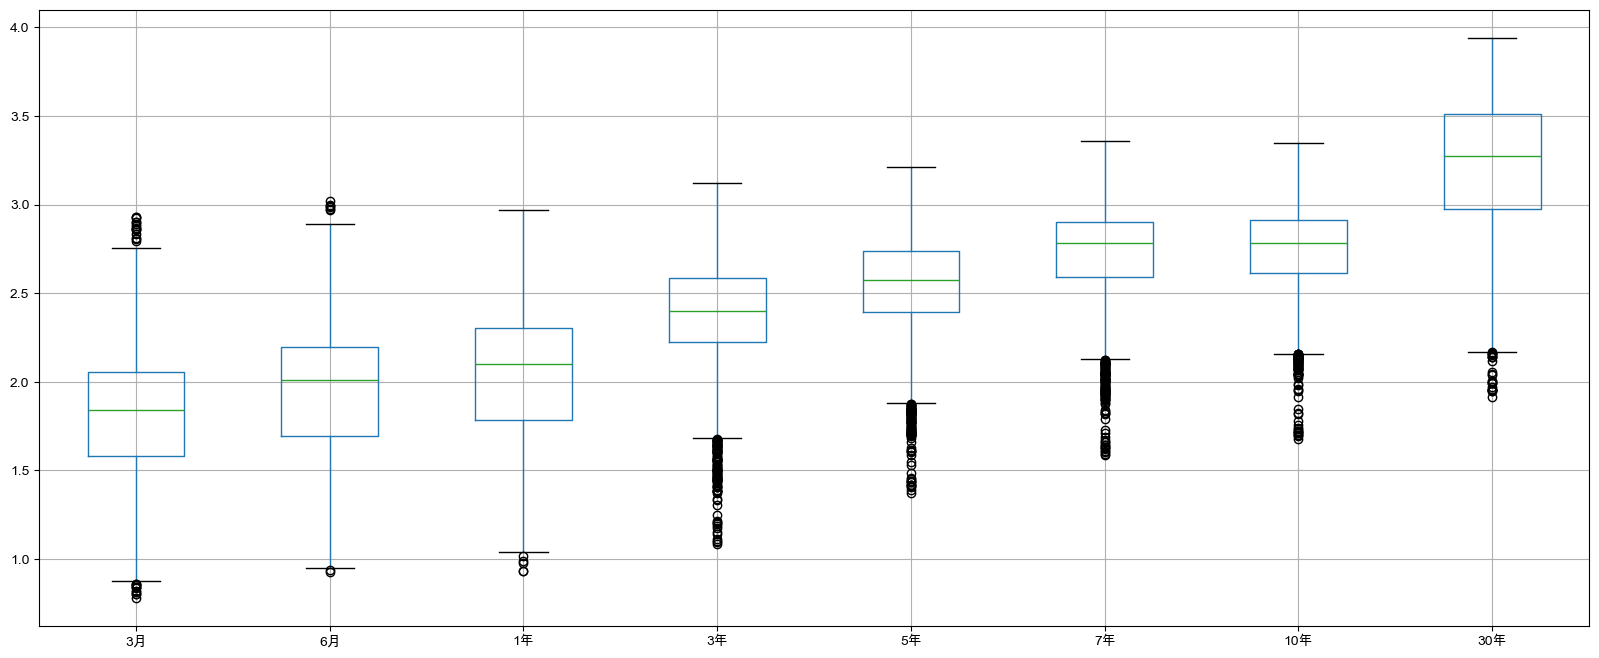

In [112]:
plt.figure(figsize=(20,8))
combined_df.boxplot()

In [113]:
df = combined_df.groupby(pd.Grouper(freq='MS')).mean().round(2)
df

,3月,6月,1年,3年,5年,7年,10年,30年
日期,,,,,,,,
2020-01-01,2.04,2.13,2.29,2.68,2.88,3.03,3.09,3.67
2020-02-01,1.73,1.79,1.97,2.41,2.62,2.80,2.83,3.44
2020-03-01,1.60,1.71,1.86,2.21,2.47,2.66,2.65,3.29
2020-04-01,1.00,1.10,1.25,1.64,2.01,2.44,2.54,3.28
2020-05-01,1.08,1.22,1.33,1.66,2.07,2.57,2.68,3.48
2020-06-01,1.80,1.98,2.04,2.33,2.53,2.85,2.83,3.57
2020-07-01,1.94,2.05,2.20,2.54,2.71,2.95,2.95,3.68
2020-08-01,2.13,2.33,2.33,2.74,2.86,3.04,2.99,3.73
2020-09-01,2.30,2.57,2.60,2.89,3.02,3.17,3.11,3.81


ACF and PACF plots of the differenced time series helps us determine if we should use AR, MA, or both components.  

ACF plot - MA(q)
1. If the stationarized time series has positive autocorrealtion at lag 1, AR terms are best. If it has negative autocorrealtion at lag 1, MA terms are best.
2. Decay and cut off of the ACF gives us hints at what terms to use.
3. Look for a cutoff point in the ACF plot. The lag at which the ACF plot drops to zero or becomes insignificant suggests the order of q.

PACF plot - AR(p)
1. If the partial autocorrelation abruptly drops off at lag k, it indicates an AR model.
2. If it drops off gradually, it suggests an MA model.
3. Look for a cutoff point in the PACF plot. The lag at which the PACF plot drops to zero or becomes statistically insignificant (meaning spikes fall within the confidence interval) suggests the order of p.

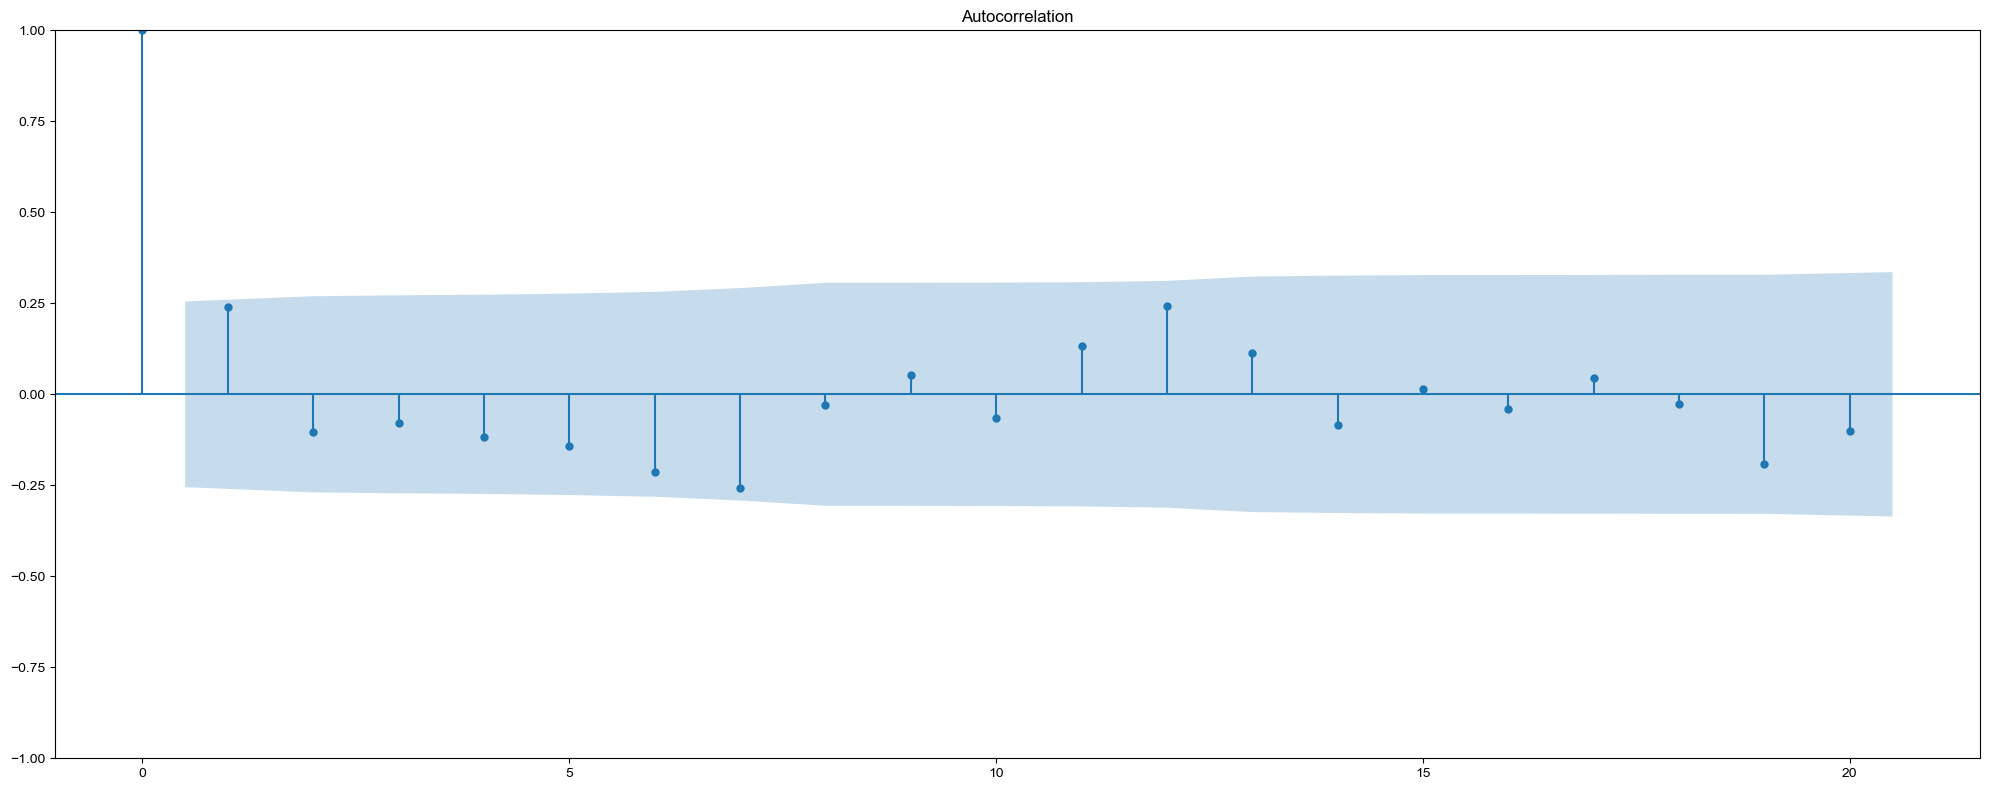

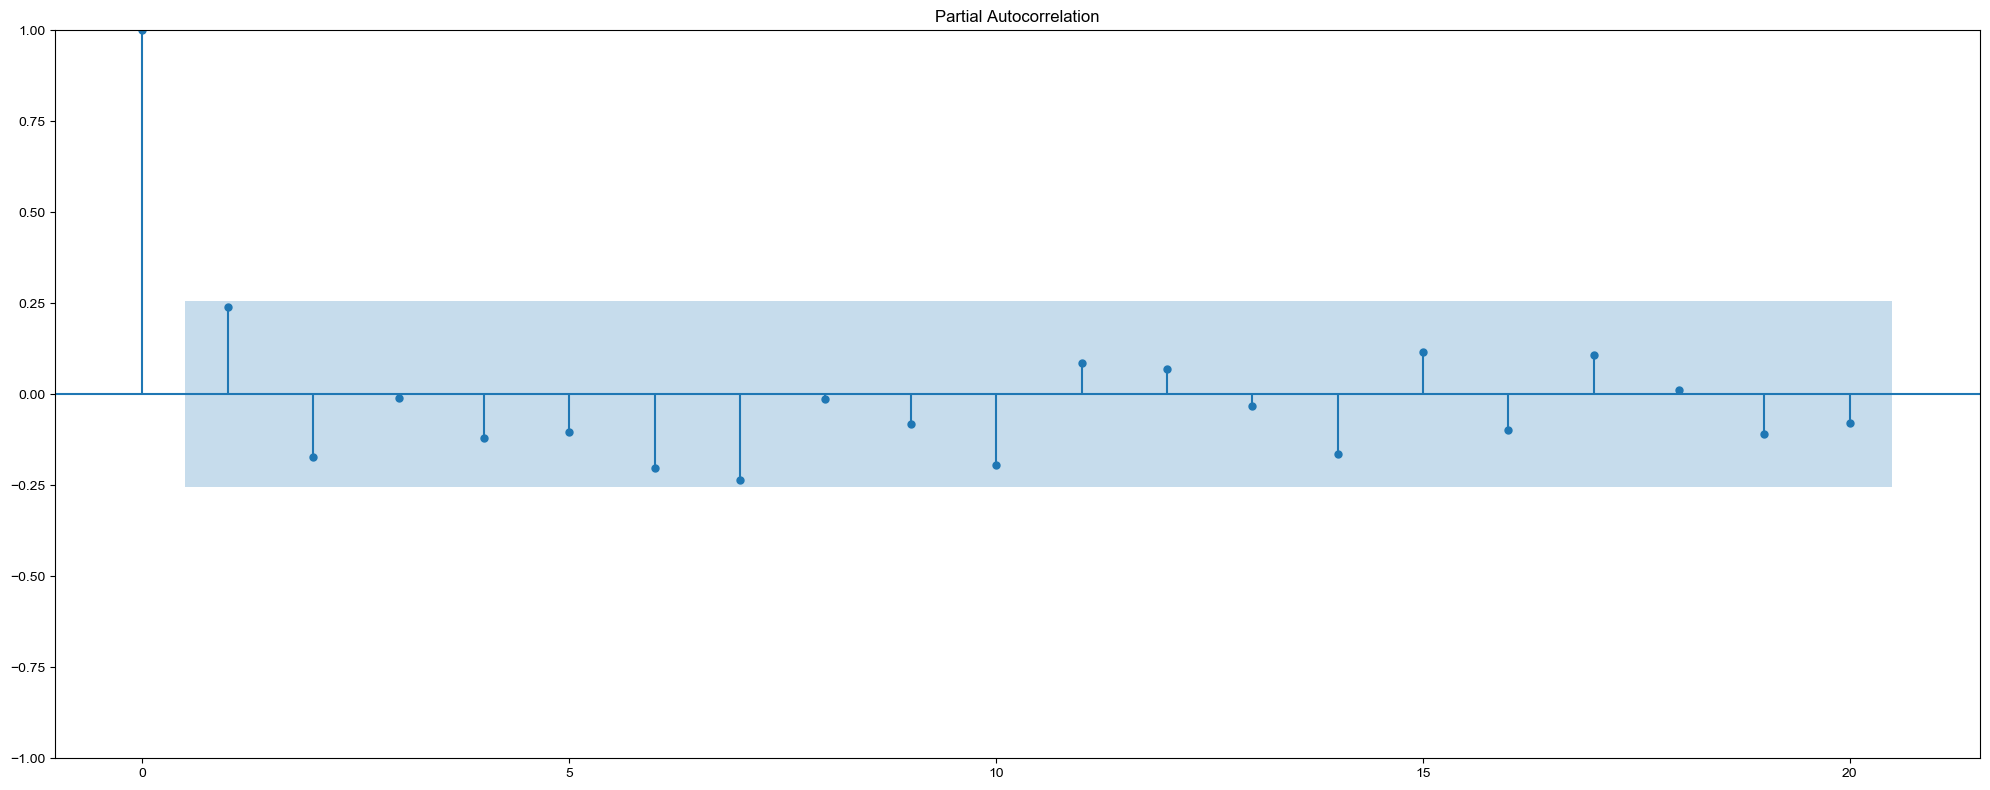

In [185]:
fig = plot_acf(df.diff()['3月'].dropna(),lags=20)
fig.set_size_inches((20,8))
# Tight layout to realign things
fig.tight_layout()
fig = plot_pacf(df.diff()['3月'].dropna(),lags=20)
fig.set_size_inches((20,8))
# Tight layout to realign things
fig.tight_layout()
plt.show()

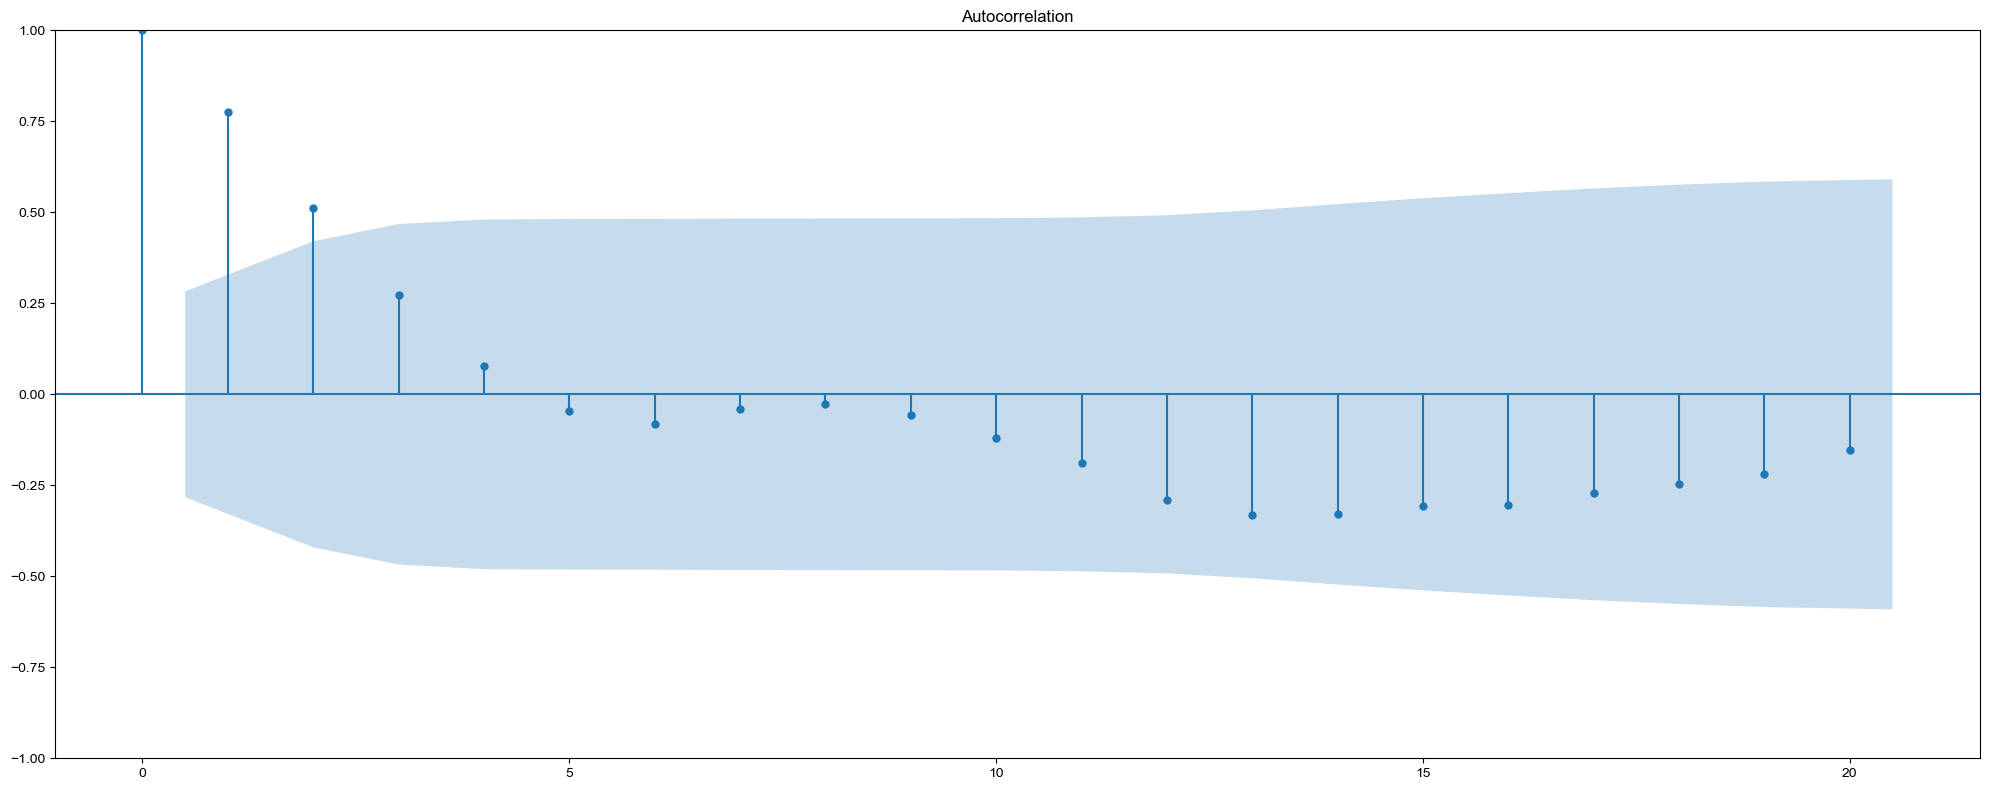

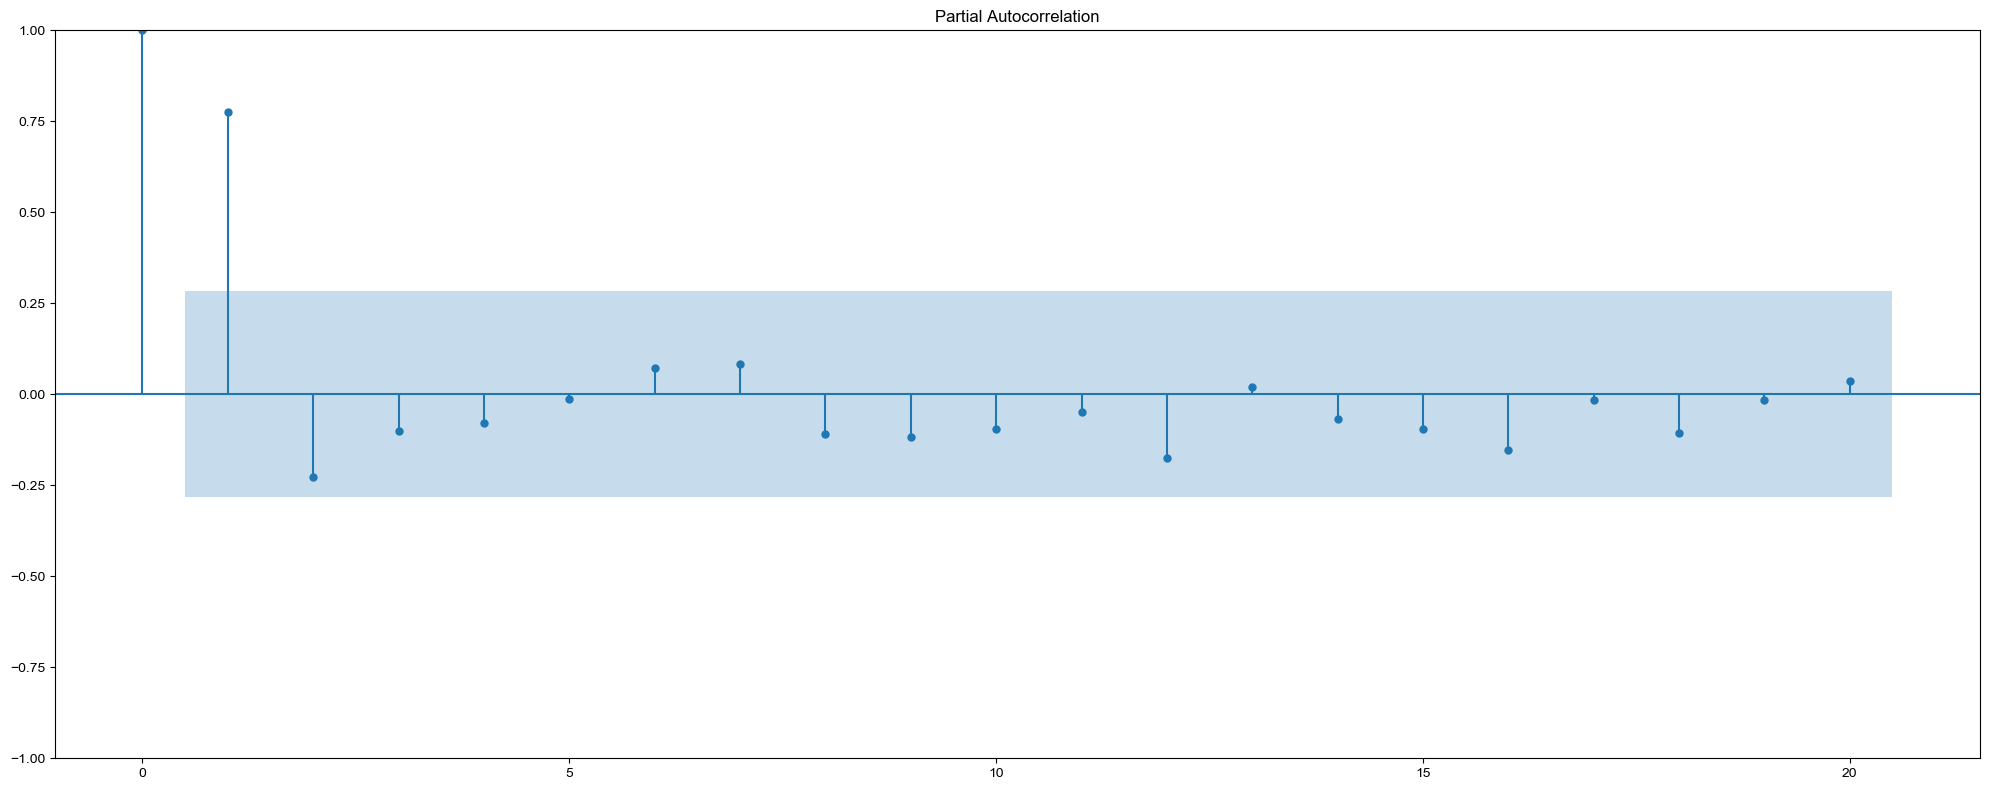

In [186]:
fig = plot_acf(df.diff(12)['3月'].dropna(),lags=20)
fig.set_size_inches((20,8))
# Tight layout to realign things
fig.tight_layout()
fig = plot_pacf(df.diff(12)['3月'].dropna(),lags=20)
fig.set_size_inches((20,8))
# Tight layout to realign things
fig.tight_layout()
plt.show()

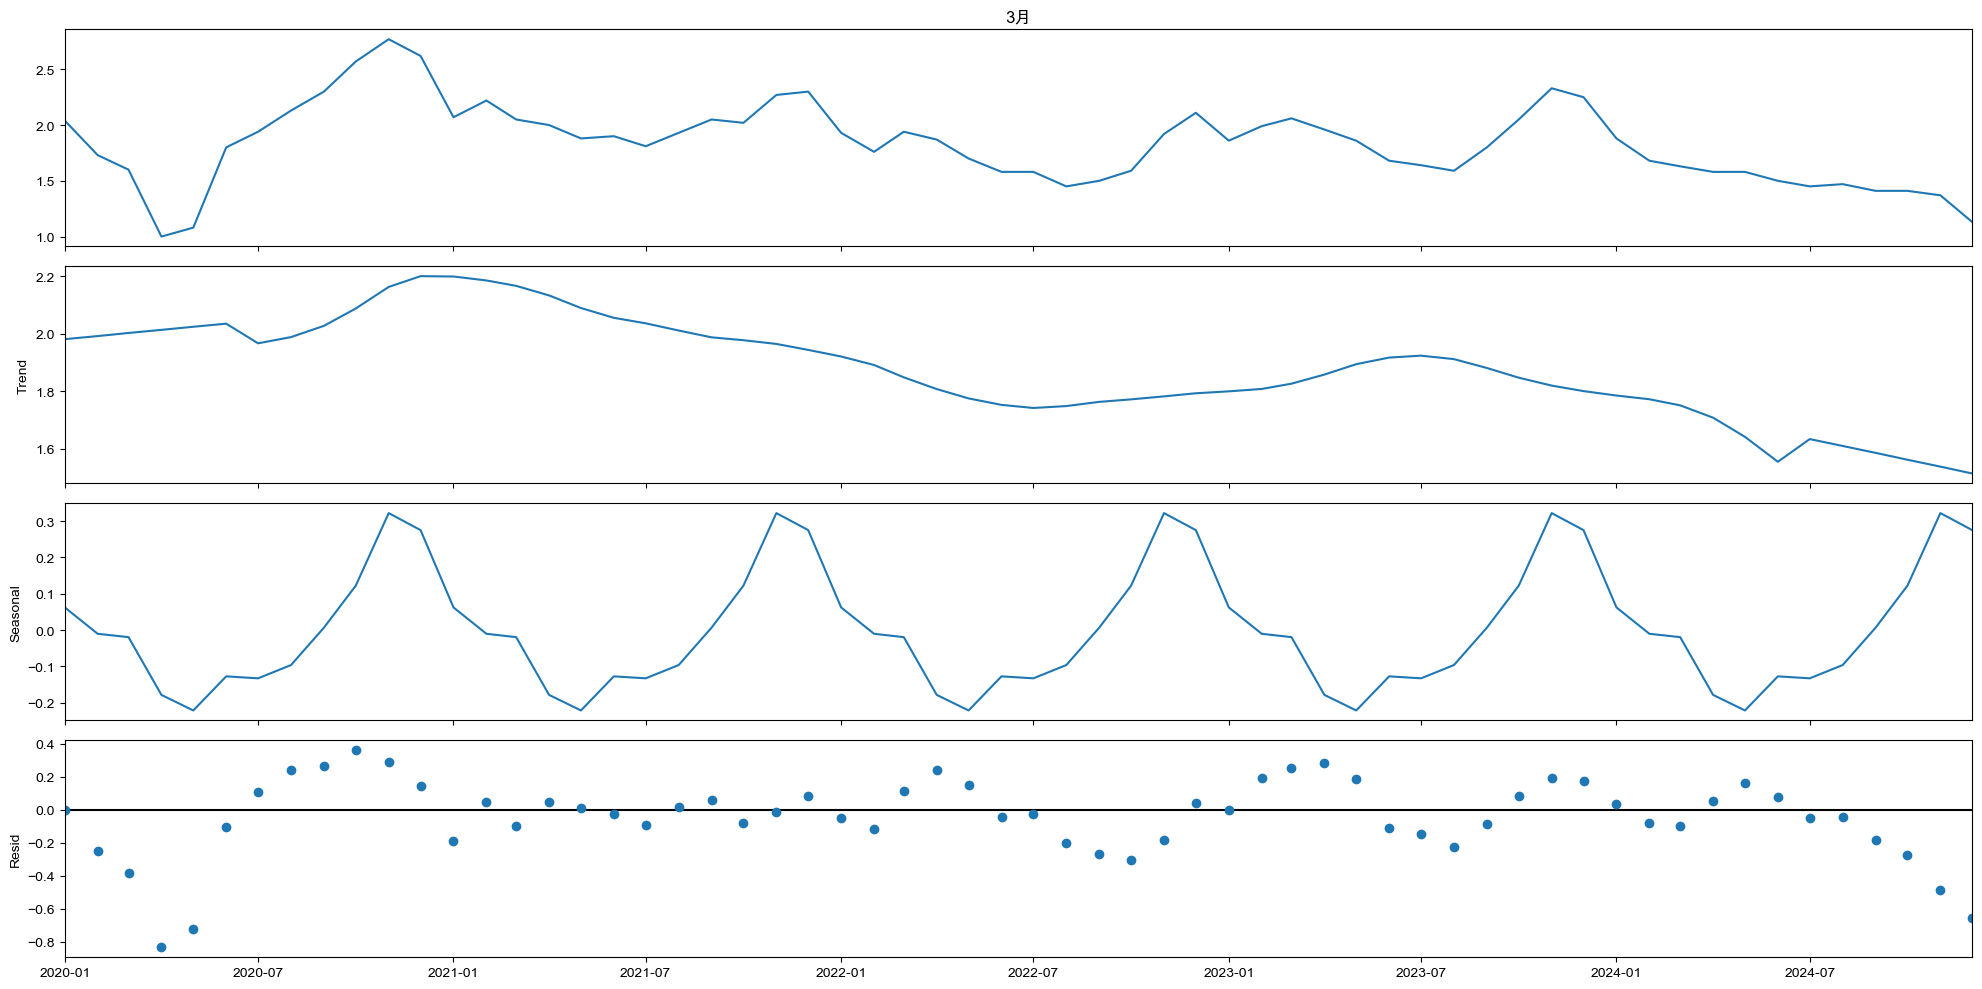

In [114]:
res = sm.tsa.seasonal_decompose(df['3月'], period=12,extrapolate_trend='freq')
fig = res.plot()
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

### Visualization

(8, 60)
(8, 60)
(8, 60)


<Figure size 1000x600 with 0 Axes>

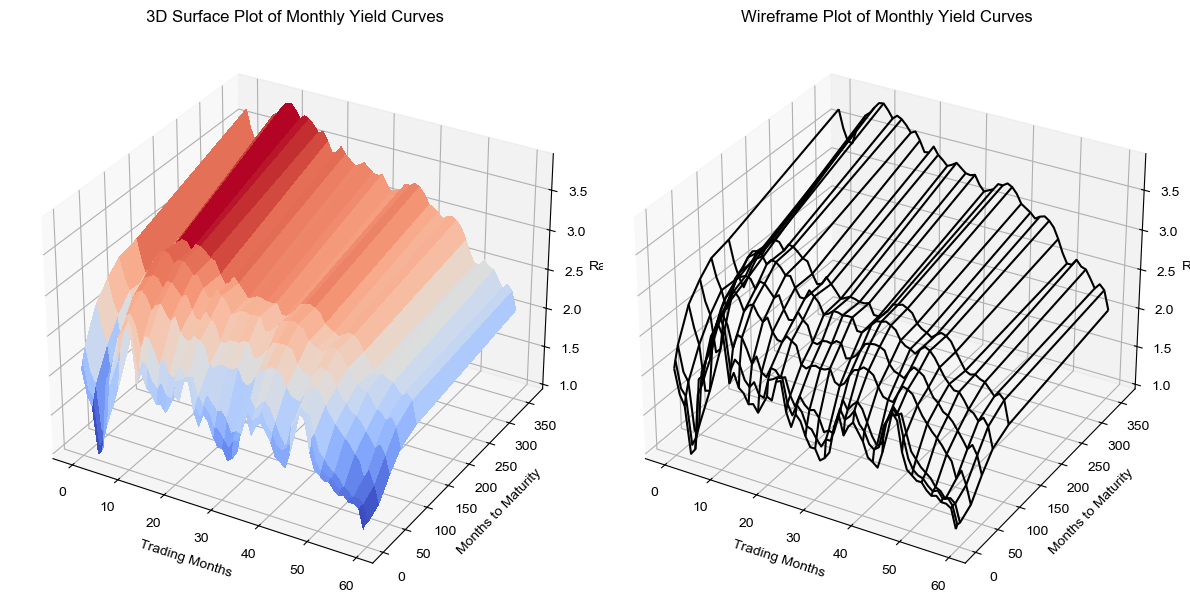

In [115]:
plt.figure(figsize=(10,6))
mtm=[3,6,12,36,60,84,120,360]
trading_days=[]
rate=[]
for i in range(0,len(df)):
    trading_days.append(i)
    rate.append(df.iloc[i,:])

X,Y = np.meshgrid(trading_days,mtm)
Z = np.array(rate,dtype=float).T
print(X.shape)
print(Y.shape)
print(Z.shape)
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax1.set_xlabel('Trading Months')
ax1.set_ylabel('Months to Maturity')
ax1.set_zlabel('Rate')
ax1.set_title('3D Surface Plot of Monthly Yield Curves')

# 3D Wireframe Plot
ax2 = fig.add_subplot(122, projection='3d')
wire = ax2.plot_wireframe(X, Y, Z, color='black')
ax2.set_xlabel('Trading Months')
ax2.set_ylabel('Months to Maturity')
ax2.set_zlabel('Rate')
ax2.set_title('Wireframe Plot of Monthly Yield Curves')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

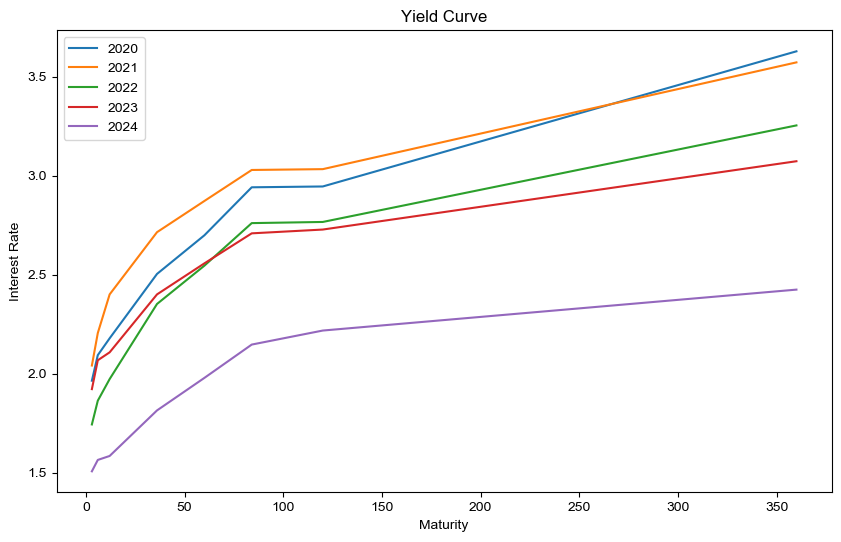

In [ ]:
#plot yield curve
plt.figure(figsize=(10,6))
yearly_avg = df.groupby(df.index.year).mean()  # Group by year and calculate yearly averages
plt.figure(figsize=(10, 6))
for year in yearly_avg.index:
    plt.plot(mtm, yearly_avg.loc[year, :], label=str(year))
plt.legend()
plt.title('Yield Curve')
plt.xlabel('Maturity')
plt.ylabel('Interest Rate')
plt.show()

<Figure size 1000x600 with 0 Axes>

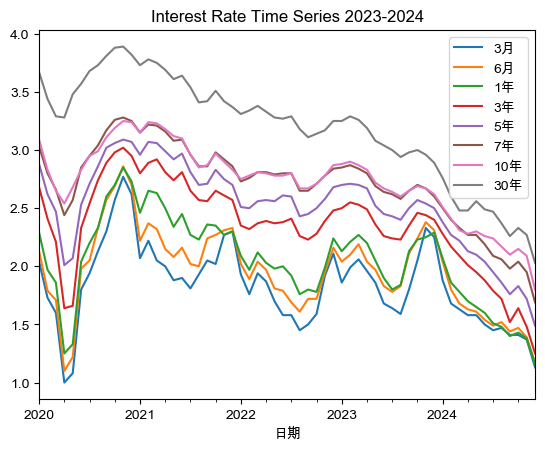

In [117]:
#plot interest rate curve
plt.rcParams["font.family"] = 'Arial Unicode MS'
plt.figure(figsize=(10,6))
df.plot()
plt.title('Interest Rate Time Series 2023-2024')
plt.show()


### Test Stationarity
1. white noise? Stationary?   
2. Trend / Seasonality?
3. Additive / Multiplicative
4. correlations?

In [ ]:
#test stationarity
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f' Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [137]:
for name,column in df.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "3月" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8762
 No. Lags Chosen       = 1
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.0482. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "6月" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.0808
 No. Lags Chosen       = 7
 Critical value 1%     = -3.563
 Critical value 5%     = -2.919
 Critical value 10%    = -2.597
 => P-Value = 0.9647. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "1年" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signific

In [120]:
diff_df = df.diff().dropna()
for name,column in diff_df.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "3月" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8746
 No. Lags Chosen       = 0
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "6月" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9809
 No. Lags Chosen       = 3
 Critical value 1%     = -3.555
 Critical value 5%     = -2.916
 Critical value 10%    = -2.596
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "1年" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [155]:
season_diff_df = df.diff(12).dropna()
for name,column in season_diff_df.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "3月" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3647
 No. Lags Chosen       = 9
 Critical value 1%     = -3.616
 Critical value 5%     = -2.941
 Critical value 10%    = -2.609
 => P-Value = 0.5991. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "6月" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0659
 No. Lags Chosen       = 8
 Critical value 1%     = -3.61
 Critical value 5%     = -2.939
 Critical value 10%    = -2.608
 => P-Value = 0.2585. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "1年" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non

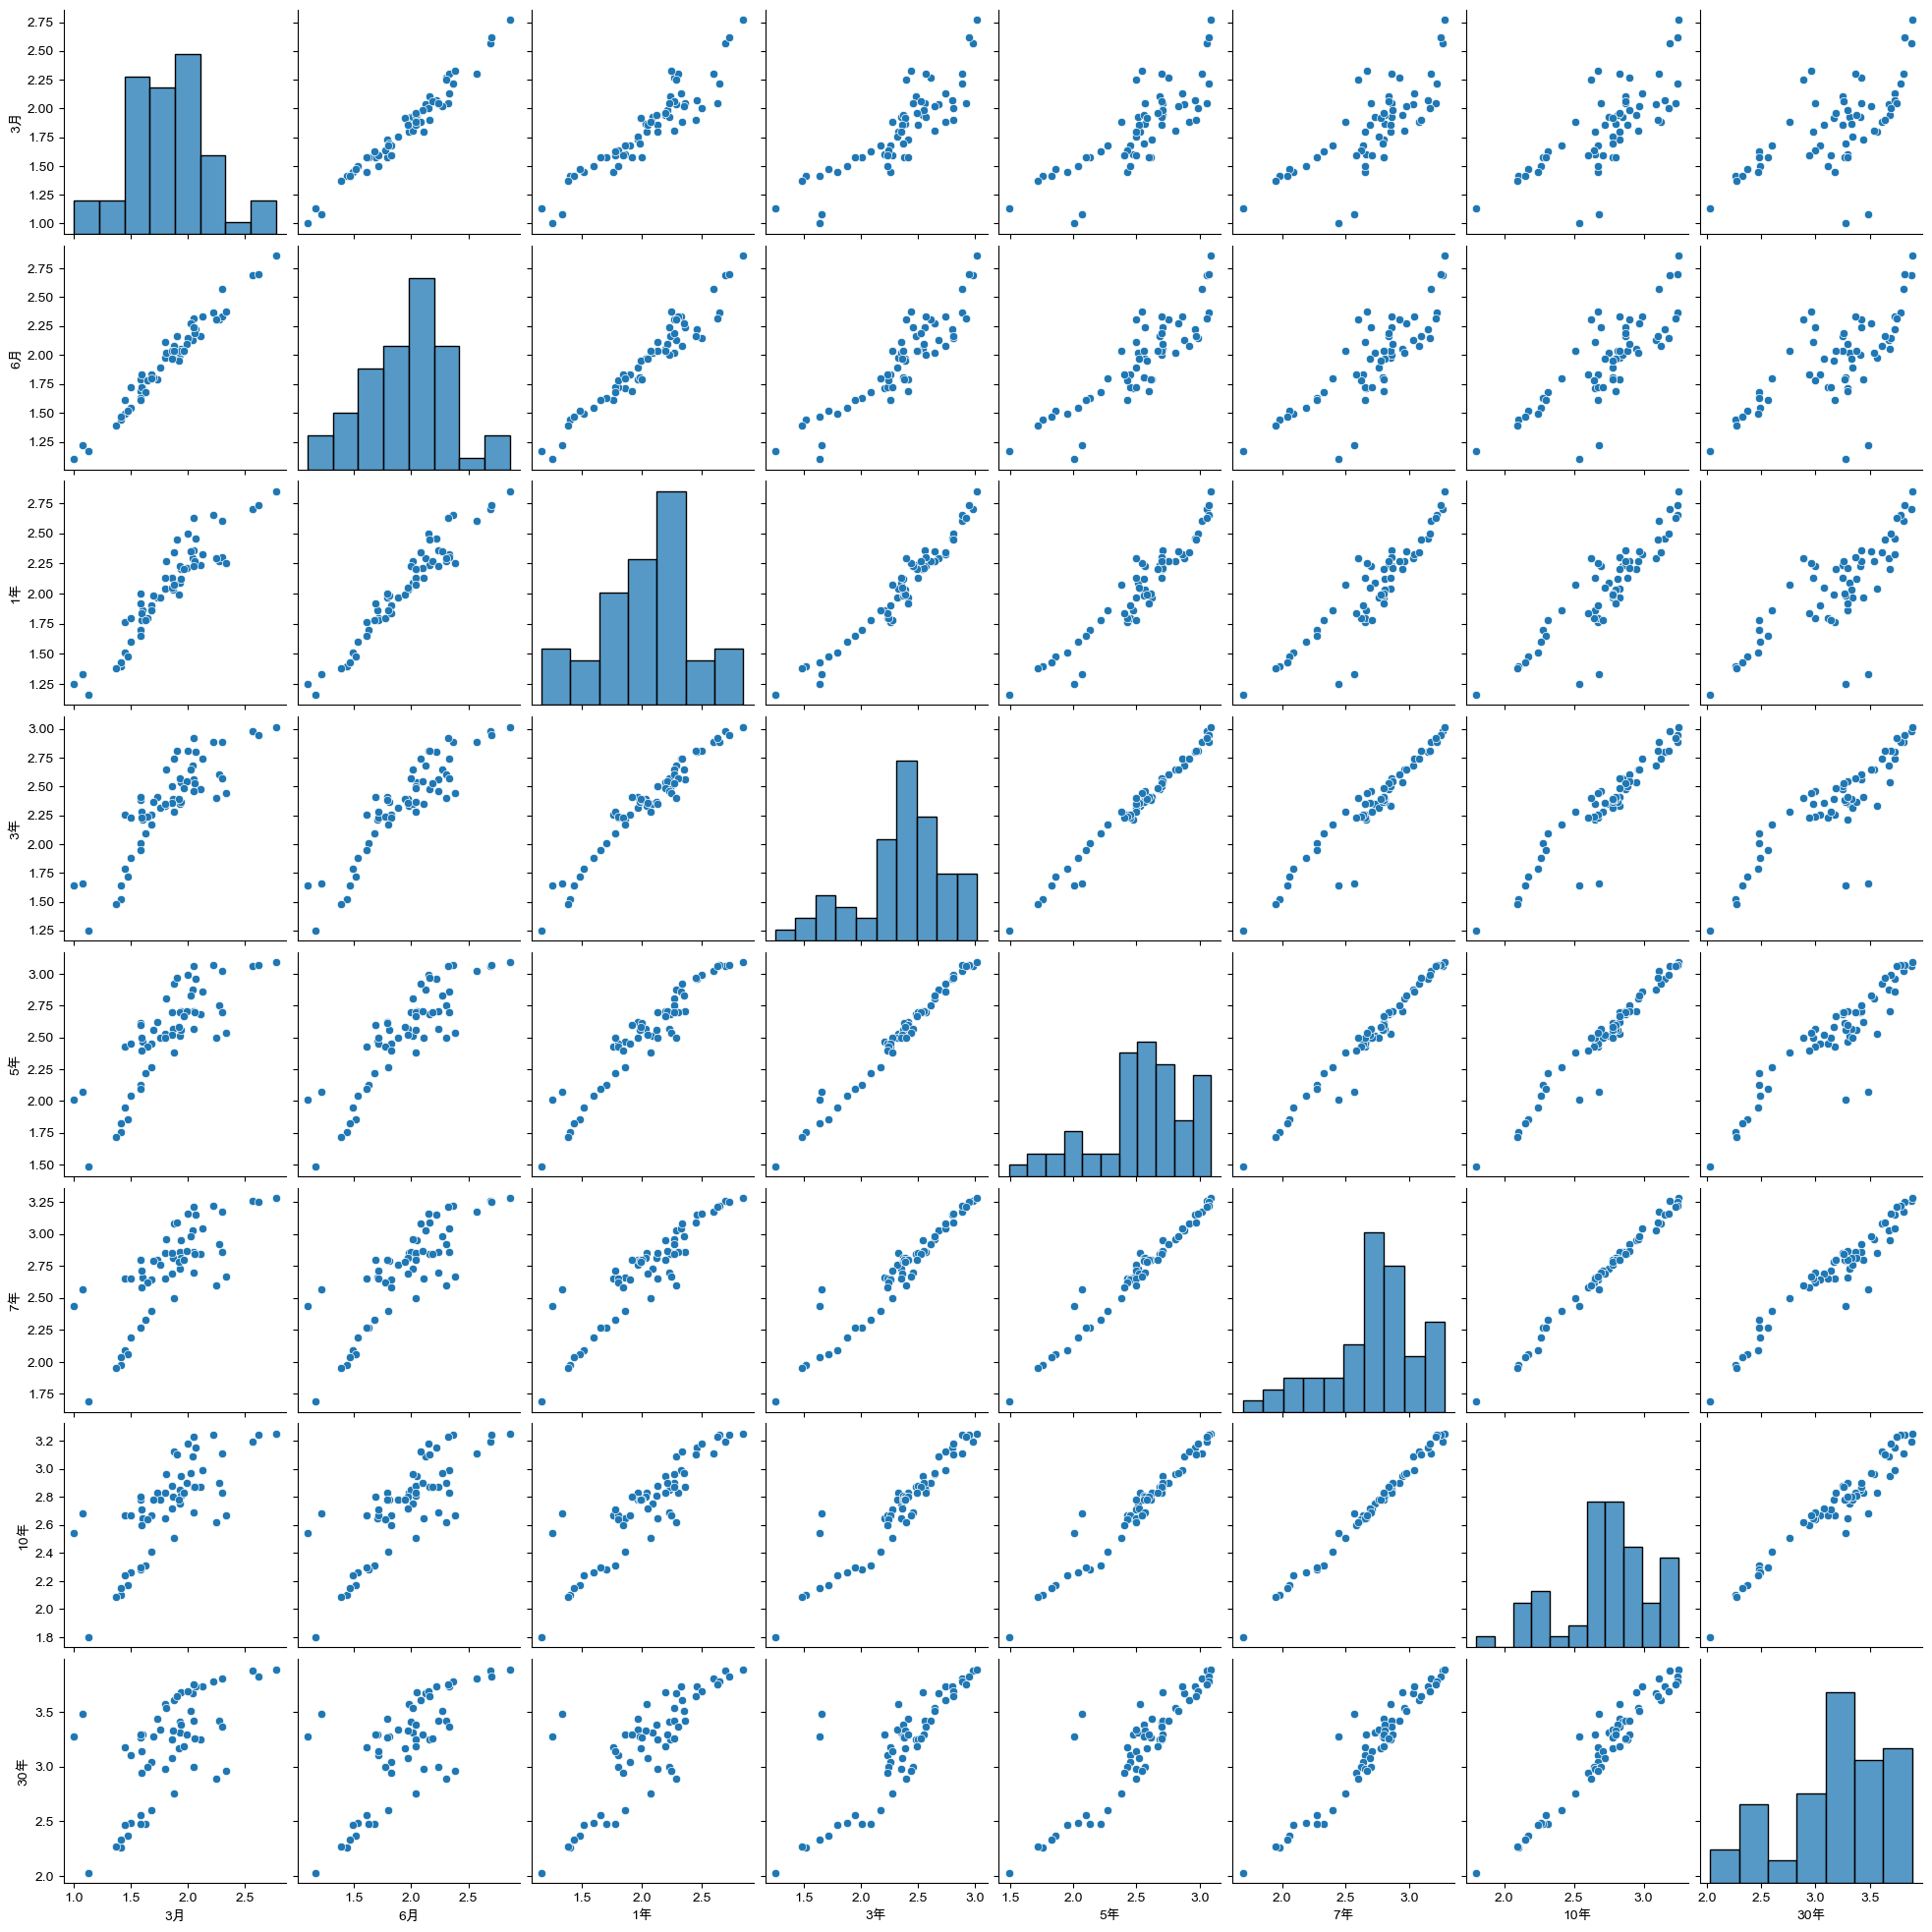

In [121]:
sns.pairplot(df)

In [122]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,3月,6月,1年,3年,5年,7年,10年,30年
3月,1.000000,0.980932,0.927310,0.856389,0.809425,0.754440,0.731308,0.626115
6月,0.980932,1.000000,0.965129,0.908351,0.868733,0.817291,0.793745,0.690903
1年,0.927310,0.965129,1.000000,0.971561,0.949756,0.905426,0.890601,0.791003
3年,0.856389,0.908351,0.971561,1.000000,0.990979,0.957787,0.941103,0.855123
5年,0.809425,0.868733,0.949756,0.990979,1.000000,0.984059,0.973811,0.905224
7年,0.754440,0.817291,0.905426,0.957787,0.984059,1.000000,0.994948,0.961199
10年,0.731308,0.793745,0.890601,0.941103,0.973811,0.994948,1.000000,0.966584
30年,0.626115,0.690903,0.791003,0.855123,0.905224,0.961199,0.966584,1.000000


In [123]:
corr1 = df.diff().corr()
corr1.style.background_gradient(cmap='coolwarm')

,3月,6月,1年,3年,5年,7年,10年,30年
3月,1.000000,0.938500,0.883346,0.798614,0.767514,0.731351,0.629805,0.517460
6月,0.938500,1.000000,0.952902,0.864010,0.848782,0.794355,0.680544,0.572199
1年,0.883346,0.952902,1.000000,0.908216,0.909707,0.837409,0.731546,0.605995
3年,0.798614,0.864010,0.908216,1.000000,0.973970,0.901307,0.766268,0.629558
5年,0.767514,0.848782,0.909707,0.973970,1.000000,0.945090,0.837478,0.695670
7年,0.731351,0.794355,0.837409,0.901307,0.945090,1.000000,0.941152,0.846505
10年,0.629805,0.680544,0.731546,0.766268,0.837478,0.941152,1.000000,0.928449
30年,0.517460,0.572199,0.605995,0.629558,0.695670,0.846505,0.928449,1.000000


In [124]:
corr2=df.diff(12).corr()
corr2.style.background_gradient(cmap='coolwarm')

,3月,6月,1年,3年,5年,7年,10年,30年
3月,1.000000,0.982695,0.943972,0.895864,0.857959,0.835244,0.811722,0.788280
6月,0.982695,1.000000,0.970013,0.933825,0.903868,0.884890,0.861559,0.840408
1年,0.943972,0.970013,1.000000,0.974119,0.956007,0.931058,0.921946,0.876690
3年,0.895864,0.933825,0.974119,1.000000,0.992497,0.972095,0.955738,0.908637
5年,0.857959,0.903868,0.956007,0.992497,1.000000,0.987532,0.978186,0.934542
7年,0.835244,0.884890,0.931058,0.972095,0.987532,1.000000,0.989929,0.972210
10年,0.811722,0.861559,0.921946,0.955738,0.978186,0.989929,1.000000,0.974272
30年,0.788280,0.840408,0.876690,0.908637,0.934542,0.972210,0.974272,1.000000


In [125]:
corr3 = df.diff().diff(12).corr()
corr3.style.background_gradient(cmap='coolwarm')

,3月,6月,1年,3年,5年,7年,10年,30年
3月,1.000000,0.915040,0.867816,0.765148,0.706737,0.671959,0.581850,0.500870
6月,0.915040,1.000000,0.925637,0.859777,0.816560,0.783698,0.709991,0.645625
1年,0.867816,0.925637,1.000000,0.904576,0.891330,0.863638,0.811321,0.714031
3年,0.765148,0.859777,0.904576,1.000000,0.968401,0.915375,0.815903,0.658283
5年,0.706737,0.816560,0.891330,0.968401,1.000000,0.959208,0.879807,0.718340
7年,0.671959,0.783698,0.863638,0.915375,0.959208,1.000000,0.948289,0.842592
10年,0.581850,0.709991,0.811321,0.815903,0.879807,0.948289,1.000000,0.915897
30年,0.500870,0.645625,0.714031,0.658283,0.718340,0.842592,0.915897,1.000000


### split into train test dataset

In [228]:
from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(df['3月'],test_size=12,shuffle=False)
print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 48
No. of testing examples: 12


In [229]:
train_data

日期
2020-01-01    2.04
2020-02-01    1.73
2020-03-01    1.60
2020-04-01    1.00
2020-05-01    1.08
2020-06-01    1.80
2020-07-01    1.94
2020-08-01    2.13
2020-09-01    2.30
2020-10-01    2.57
2020-11-01    2.77
2020-12-01    2.62
2021-01-01    2.07
2021-02-01    2.22
2021-03-01    2.05
2021-04-01    2.00
2021-05-01    1.88
2021-06-01    1.90
2021-07-01    1.81
2021-08-01    1.93
2021-09-01    2.05
2021-10-01    2.02
2021-11-01    2.27
2021-12-01    2.30
2022-01-01    1.93
2022-02-01    1.76
2022-03-01    1.94
2022-04-01    1.87
2022-05-01    1.70
2022-06-01    1.58
2022-07-01    1.58
2022-08-01    1.45
2022-09-01    1.50
2022-10-01    1.59
2022-11-01    1.92
2022-12-01    2.11
2023-01-01    1.86
2023-02-01    1.99
2023-03-01    2.06
2023-04-01    1.96
2023-05-01    1.86
2023-06-01    1.68
2023-07-01    1.64
2023-08-01    1.59
2023-09-01    1.80
2023-10-01    2.05
2023-11-01    2.33
2023-12-01    2.25
Freq: MS, Name: 3月, dtype: float64

In [230]:
test_data

日期
2024-01-01    1.88
2024-02-01    1.68
2024-03-01    1.63
2024-04-01    1.58
2024-05-01    1.58
2024-06-01    1.50
2024-07-01    1.45
2024-08-01    1.47
2024-09-01    1.41
2024-10-01    1.41
2024-11-01    1.37
2024-12-01    1.13
Freq: MS, Name: 3月, dtype: float64

### fitting models

In [231]:
triple_ets_add = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()
triple_ets_add_pred = triple_ets_add.forecast(12)
triple_ets_mul_pred = triple_ets_mul.forecast(12)


In [232]:
manual_model = sm.tsa.ARIMA(train_data, order=(1,1,2))
manual_model_fit = manual_model.fit()
print(manual_model_fit.summary())
manu_arima = manual_model_fit.forecast(steps=12)

                               SARIMAX Results                                
Dep. Variable:                     3月   No. Observations:                   48
Model:                 ARIMA(1, 1, 2)   Log Likelihood                   7.365
Date:                Wed, 22 Jan 2025   AIC                             -6.730
Time:                        23:44:23   BIC                              0.671
Sample:                    01-01-2020   HQIC                            -3.945
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6568      0.154      4.252      0.000       0.354       0.960
ma.L1         -0.5790      6.323     -0.092      0.927     -12.972      11.814
ma.L2         -0.4196      2.652     -0.158      0.8

In [233]:
# Define SARIMA parameters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Assumes seasonal period is 12 months (annual seasonality)

best_aic = np.inf
best_order = None
best_seasonal_order = None

# Find the best SARIMA-X model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.SARIMAX(train_data,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04106D+00    |proj g|=  1.04211D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   1.462D-07   2.041D+00
  F =   2.0410555609472665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.4

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     34      1     0     0   1.143D-04  -6.831D-03
  F =  -6.8314287100303605E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92502D+00    |proj g|=  6.01561D-01

At iterate    5    f=  1.40179D+00    |proj g|=  6.59661D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f= -9.98145D-02    |proj g|=  3.74736D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     19      1     0     0   8.222D-05  -9.981D-02
  F =  -9.9814457928199971E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44342D+00    |proj g|=  5.20857D-01

At iterate    5    f=  9.53018D-02    |proj g|=  1.23876D+00

At iterate   10    f=  4.39756D-02    |proj g|=  5.70397D-03

       

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f= -1.87843D-01    |proj g|=  1.13855D-01

At iterate   15    f= -1.92419D-01    |proj g|=  2.03357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     34      1     0     0   2.213D-04  -1.924D-01
  F = -0.19241956904293225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.63122D-02    |proj g|=  1.00201D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be se


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     74      3     2     0   7.462D+04   1.336D+01
  F =   13.360335485541846     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.31252D-02    |proj g|=  7.13392D-01

At iterate    5    f= -4.99933D-02    |proj g|=  2.93138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search 


At iterate   10    f= -3.12759D-01    |proj g|=  2.65499D-01

At iterate   15    f= -3.14387D-01    |proj g|=  3.56235D-02

At iterate   20    f= -3.14423D-01    |proj g|=  5.42312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     42      1     0     0   1.260D-03  -3.144D-01
  F = -0.31442284010752569     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92952D-02    |proj g|=  3.55450D-04

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  wa


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4     83      4     2     0   1.027D+04   1.418D+01
  F =   14.182624428104971     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66058D-01    |proj g|=  1.11038D+00

At iterate    5    f= -2.16042D-01    |proj g|=  6.28446D-02

At iterate   10    f= -2.16178D-01    |proj g|=  1.95422D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30072D-02    |proj g|=  8.22513D-01

At iterate    5    f= -3.13955D-01    |proj g|=  1.30952D+00

At iterate   10    f= -3.60985D-01    |proj g|=  4.86792D-03

At iterate   15    f= -3.61014D-01    |proj g|=  4.87336D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   6.940D-06  -3.610D-01
  F = -0.36101415583499269     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     53      2     0     0   9.452D-05  -3.089D-01
  F = -0.30888260315635147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.97879D-02    |proj g|=  1.97396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     81      2     2     0   3.266D+05   1.109D+01
  F =   11.088797915434943     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56888D-01    |proj g|=  1.05789D+00

At iterate    5    f= -2.06520D-01    |proj g|=  2.26469D-02

At iterate   10    f= -2.07416D-01    |proj g|=  1.55056D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   25    f= -2.58037D-01    |proj g|=  7.49712D-02

At iterate   30    f= -2.58433D-01    |proj g|=  2.69007D-02

At iterate   35    f= -2.58669D-01    |proj g|=  2.64655D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     58      1     0     0   2.647D-01  -2.587D-01
  F = -0.25866893862321205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.04234D-01    |proj g|=  1.85313D+00

At iter

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [221]:
print(f'Best SARIMA-X model order: {best_order}')
print(f'Best SARIMA-X model seasonal order: {best_seasonal_order}')

Best SARIMA-X model order: (0, 1, 0)
Best SARIMA-X model seasonal order: (1, 0, 0, 12)


In [ ]:
seasonal_model = SARIMAX(train_data, order=best_order, 
                         seasonal_order=best_seasonal_order,
                         enforce_stationarity=False,
                           enforce_invertibility=False)
seasonal_model_fit = seasonal_model.fit()
print(seasonal_model_fit.summary())
manu_sarimax = seasonal_model_fit.forecast(steps=12)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.57928D-01    |proj g|=  3.29813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      5      1     0     0   2.881D-04  -3.579D-01
  F = -0.35792795203477984     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                                 3月   No. Observations:                   48
Model:      

 This problem is unconstrained.


In [234]:
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
print(smodel.summary())
auto_arima = smodel.predict(n_periods=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-1.319, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1.646, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-4.301, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-3.145, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-3.628, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-1.883, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-3.046, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-2.920, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-2.854, Time=0.05 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-1.054, Time=0.29 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-5.162, Time=0.04 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-3.403, Time=0.33 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-3.377, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-3.656, Time=0.05 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=-1.4

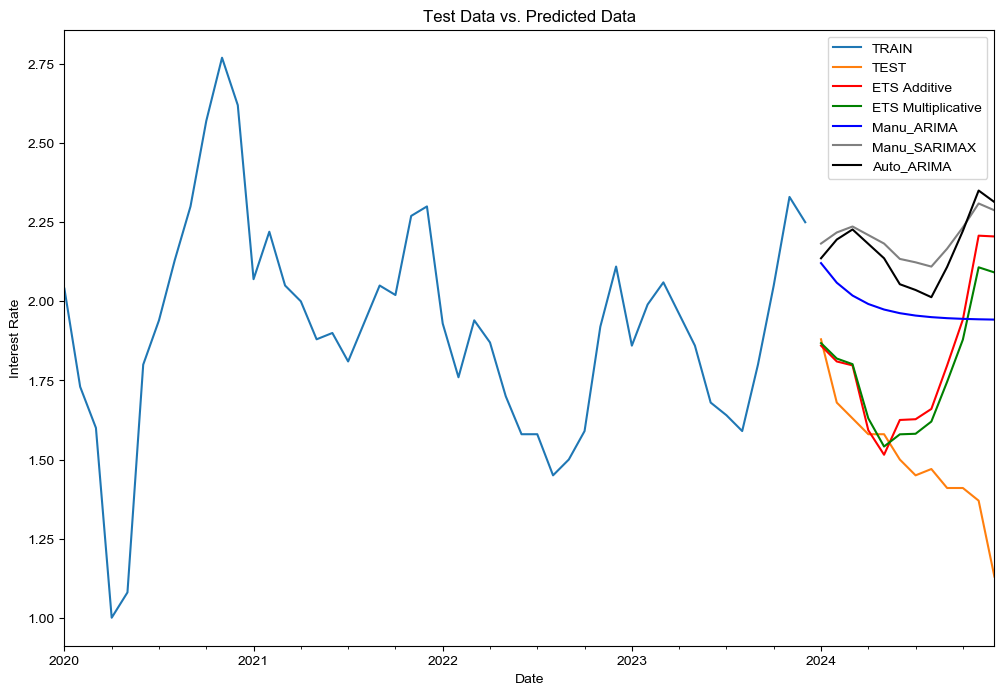

In [235]:
# Visualize predictions
plt.figure(figsize=(12, 6))
train_data.plot(legend=True, label='TRAIN')
test_data.plot(legend=True, label='TEST', figsize=(12, 8))
triple_ets_add_pred.plot(legend=True, label='ETS Additive', color='red')
triple_ets_mul_pred.plot(legend=True, label='ETS Multiplicative', color='green')
manu_arima.plot(legend=True, label='Manu_ARIMA', color='blue')
manu_sarimax.plot(legend=True, label='Manu_SARIMAX', color='grey')
auto_arima.plot(legend=True, label='Auto_ARIMA', color='black')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('Test Data vs. Predicted Data')
plt.legend()
plt.show()

### model evaluation

In [243]:
#define metrics dataframe which will be used below for storing results
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE'])

def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    df = pd.DataFrame({'Model': [model],
                       'RMSE': [rmse],
                       'MAE': [mae],
                       'MAPE': [mape]})

    global metrics_dataframe
    metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)
    return metrics_dataframe


In [244]:
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_add_pred.values.flatten(),
                                'triple_est_add')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_mul_pred.values.flatten(),
                                'triple_est_mul')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                manu_arima.values.flatten(),
                                'manu_arima')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                manu_sarimax.values.flatten(),
                                'manu_sarimax')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                auto_arima.values.flatten(),
                                'auto_arima')

/var/folders/fq/pj7v969s0rnd1fm_gl890_mh0000gn/T/ipykernel_64356/2905591202.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)


In [245]:
test_pred_df = pd.DataFrame(test_data.copy())

# Add all predictions
test_pred_df = test_pred_df.assign(manual_arima_pred = triple_ets_add_pred.values.flatten(),
                                   auto_nonseasonal_pred = triple_ets_mul_pred.values.flatten(),
                                   auto_seasonal_pred = manu_sarimax.values.flatten(),
                                   avg_pred = (triple_ets_add_pred.values.flatten()+
                                               triple_ets_mul_pred.values.flatten()+
                                              manu_sarimax.values.flatten())/3)
test_pred_df

,3月,manual_arima_pred,auto_nonseasonal_pred,auto_seasonal_pred,avg_pred
日期,,,,,
2024-01-01,1.88,1.860048,1.868010,2.182613,1.970224
2024-02-01,1.68,1.809964,1.819209,2.217654,1.948943
2024-03-01,1.63,1.797566,1.801462,2.236523,1.945184
2024-04-01,1.58,1.592645,1.630150,2.209568,1.810788
2024-05-01,1.58,1.515096,1.541111,2.182613,1.746274
2024-06-01,1.50,1.625027,1.579659,2.134095,1.779593
2024-07-01,1.45,1.627396,1.581428,2.123313,1.777379
2024-08-01,1.47,1.659902,1.620032,2.109836,1.796590
2024-09-01,1.41,1.797418,1.745708,2.166441,1.903189


In [246]:
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                test_pred_df['avg_pred'],
                                'Average')

In [247]:
metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE
1,triple_est_mul,0.397919,0.273046,20.470950
0,triple_est_add,0.449427,0.309990,23.249066
5,Average,0.500194,0.417458,30.186851
2,manu_arima,0.494884,0.476524,33.184597
4,auto_arima,0.696131,0.657076,46.000390
3,manu_sarimax,0.721478,0.691960,48.218572


### Machine Learning methods

In [293]:
#cyclical encoding
#create a new dataset by copying train_data
mutistep_df = pd.DataFrame(train_data).copy()

#create date features to cyclicaly encode month and quarter
mutistep_df['Year'] = train_data.index.year
mutistep_df['Month'] =  train_data.index.month
mutistep_df['Quarter'] =  train_data.index.quarter
#radially/cyclically encode month and quarter

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

mutistep_df = encode(mutistep_df, 'Month', 12)
mutistep_df = encode(mutistep_df, 'Quarter', 4)
mutistep_df = mutistep_df.drop(['Month', 'Quarter'], axis=1)
mutistep_df

,3月,Year,Month_sin,Month_cos,Quarter_sin,Quarter_cos
日期,,,,,,
2020-01-01,2.04,2020,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17
2020-02-01,1.73,2020,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17
2020-03-01,1.60,2020,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2020-04-01,1.00,2020,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00
2020-05-01,1.08,2020,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00
2020-06-01,1.80,2020,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00
2020-07-01,1.94,2020,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16
2020-08-01,2.13,2020,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16
2020-09-01,2.30,2020,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16


In [294]:
last_12months_data = mutistep_df.copy().tail(12)
last_12months_data

,3月,Year,Month_sin,Month_cos,Quarter_sin,Quarter_cos
日期,,,,,,
2023-01-01,1.86,2023,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17
2023-02-01,1.99,2023,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17
2023-03-01,2.06,2023,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2023-04-01,1.96,2023,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00
2023-05-01,1.86,2023,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00
2023-06-01,1.68,2023,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00
2023-07-01,1.64,2023,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16
2023-08-01,1.59,2023,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16
2023-09-01,1.80,2023,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16


In [295]:
mutistep_df['y'] = mutistep_df['3月'].shift(-1)
mutistep_df = mutistep_df.dropna()
mutistep_df

,3月,Year,Month_sin,Month_cos,Quarter_sin,Quarter_cos,y
日期,,,,,,,
2020-01-01,2.04,2020,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17,1.73
2020-02-01,1.73,2020,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17,1.60
2020-03-01,1.60,2020,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17,1.00
2020-04-01,1.00,2020,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00,1.08
2020-05-01,1.08,2020,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00,1.80
2020-06-01,1.80,2020,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00,1.94
2020-07-01,1.94,2020,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16,2.13
2020-08-01,2.13,2020,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,2.30
2020-09-01,2.30,2020,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,2.57


In [317]:
# ### Create input and output sequences (input is data from last 12 months to predict the next 12 months)

# multivariate multi-step data preparation

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps to look in the last to predict the number of time steps into the future
# look at 12 months in the past to predict the next 12 months
n_steps_in, n_steps_out = 12, 12

# convert into input/output
X_train, y_train = split_sequences(mutistep_df.values, n_steps_in, n_steps_out)

In [321]:
X_train.shape, y_train.shape


((25, 12, 6), (25, 12))

In [322]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = last_12months_data.values.flatten()

In [323]:
X_train.shape, X_test.shape

((25, 72), (72,))

In [324]:
# ### perform PCA on the X_train and X_test datasets

# first, standardize the data

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test.reshape(1, -1))

#perform pca on the standardized data
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99) #capture 99% of the variation in the dataset
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [325]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]


TRAIN: [0 1 2 3 4] TEST: [5 6 7 8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [ 9 10 11 12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17 18 19 20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21 22 23 24]


### There are two main approaches to implementing this technique.

A. The 'Direct Multioutput' approach involves developing a separate regression model for each output value to be predicted. We can think of this as a direct approach, as each target value is modeled directly. For example, if a multioutput regression problem required the prediction of three values y1, y2, and y3 given an input X, then this could be partitioned into three single-output regression problems such as follows.

1. Problem 1: Given X, predict y1
2. Problem 2: Given X, predict y2
3. Problem 3: Given X, predict y3.


B. The 'Chained Multioutput' approach is an extension of the first method except the models are organized into a chain. The prediction from the first model is taken as part of the input to the second model, and the process of output-to-input dependency repeats along the chain of models. This approach to using single-output regression models for multioutput regression is to create a linear sequence of models.

The first model in the sequence uses the input and predicts one output; the second model uses the input and the output from the first model to make a prediction; the third model uses the input and output from the first two models to make a prediction, and so on.

For example, if a multioutput regression problem required the prediction of three values y1, y2 and y3 given an input X, then this could be partitioned into three dependent single-output regression problems as follows:

1. Problem 1: Given X, predict y1
2. Problem 2: Given X and yhat1, predict y2
3. Problem 3: Given X, yhat1, and yhat2, predict y3.

In [326]:
# train the models on the past to predict the future

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor #direct multioutput wrapper
from sklearn.multioutput import RegressorChain #chained multioutput wrapper
from sklearn import model_selection


# prepare configuration for cross validation test harness
seed = 7

# prepare models to create predcitions
models = []

#direct Models
models.append(('KNeigh Direct', MultiOutputRegressor(KNeighborsRegressor())))
models.append(('RF Direct', MultiOutputRegressor(RandomForestRegressor())))
models.append(('GBR Direct', MultiOutputRegressor(GradientBoostingRegressor())))
models.append(('XGB Direct', MultiOutputRegressor(xgb.XGBRegressor())))
models.append(('LGB Direct', MultiOutputRegressor(lgb.LGBMRegressor())))
models.append(('KNeigh Chained', RegressorChain(KNeighborsRegressor())))
models.append(('RF Chained', RegressorChain(RandomForestRegressor())))
models.append(('GBR Chained', RegressorChain(GradientBoostingRegressor())))
models.append(('XGB Chained', RegressorChain(xgb.XGBRegressor())))
models.append(('LGB Chained', RegressorChain(lgb.LGBMRegressor())))


In [327]:
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_absolute_error'
for name, model in models:
    tscv = TimeSeriesSplit(n_splits=5)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=tscv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


KNeigh Direct: -0.208508 (0.039689)
RF Direct: -0.229141 (0.020788)
GBR Direct: -0.236345 (0.016514)
XGB Direct: -0.249289 (0.032537)
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 5, number of used features: 0
[LightGBM] [Info] Start training from score 2.044000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no m

In [328]:
results

[array([-0.23108333, -0.25208333, -0.23116667, -0.18658333, -0.141625  ]),
 array([-0.23093958, -0.256975  , -0.23400208, -0.19234792, -0.23144167]),
 array([-0.24123546, -0.24656434, -0.23220755, -0.20679768, -0.25492224]),
 array([-0.2856767 , -0.28422167, -0.2308311 , -0.20037493, -0.24533893]),
 array([-0.23108333, -0.26967591, -0.26746794, -0.20909314, -0.16456349]),
 array([-0.23108333, -0.25208333, -0.23116667, -0.18658333, -0.141625  ]),
 array([-0.23152917, -0.24841458, -0.24295833, -0.18429167, -0.23427917]),
 array([-0.23424266, -0.26356463, -0.2306153 , -0.22729507, -0.27923569]),
 array([-0.2856767 , -0.29721443, -0.23345658, -0.20488999, -0.24243616]),
 array([-0.23108333, -0.26967591, -0.26746794, -0.20909314, -0.16456349])]

In [329]:
# Calculate median and std deviation separately
medians = [np.median(result) for result in results]
std_deviations = [result.std() for result in results]

# Create a dictionary to store the results
results_dict = {
    'Model': names,
    'Mean MAE': [result.mean() for result in results],
    'Median MAE': medians,
    'Std Deviation': std_deviations
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

# Sort the DataFrame by the absolute value of Median MAE and Std Deviation in ascending order
sorted_results_df = results_df.reindex(
    results_df.apply(lambda row: (abs(row['Median MAE']), row['Std Deviation']), axis=1)
                 .sort_values().index)

# Print the sorted DataFrame
sorted_results_df

,Model,Mean MAE,Median MAE,Std Deviation
4,LGB Direct,-0.228377,-0.231083,0.039205
9,LGB Chained,-0.228377,-0.231083,0.039205
0,KNeigh Direct,-0.208508,-0.231083,0.039689
5,KNeigh Chained,-0.208508,-0.231083,0.039689
1,RF Direct,-0.229141,-0.231442,0.020788
7,GBR Chained,-0.246991,-0.234243,0.020654
6,RF Chained,-0.228295,-0.234279,0.022814
2,GBR Direct,-0.236345,-0.241235,0.016514
8,XGB Chained,-0.252735,-0.242436,0.034148
3,XGB Direct,-0.249289,-0.245339,0.032537


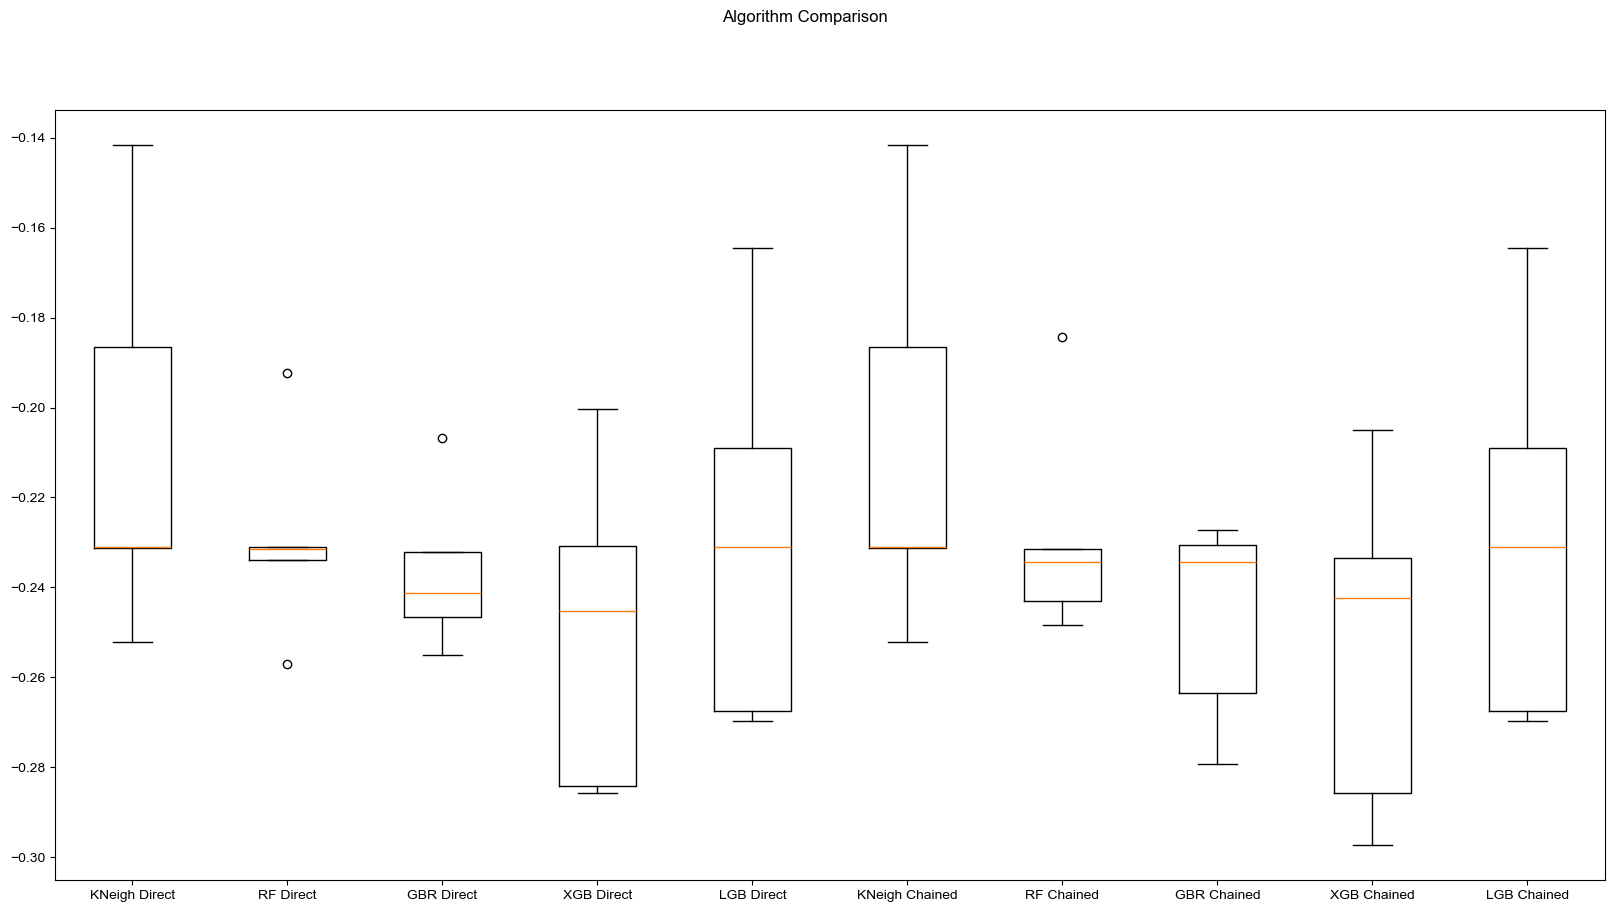

In [330]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(20,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
#find the model with the lowest median MAE and Std Deviation(spread)

In [331]:
# prepare models to create predcitions
prediction_models = []

#direct Models
prediction_models.append(('KNeigh Direct', MultiOutputRegressor(KNeighborsRegressor())))
prediction_models.append(('LGB Direct', MultiOutputRegressor(lgb.LGBMRegressor())))
prediction_models.append(('RF Direct', MultiOutputRegressor(RandomForestRegressor())))

# create a dataframe to store the multivariate predictions
multivariate_pred = pd.DataFrame(index=test_data.index)

#run the different ML models to create the predictions dataset
for name, model in prediction_models:
    model.fit(X_train, y_train)
    #create preictions for the next 12 months
    yhat = model.predict(X_test)
    multivariate_pred[name +'_predictions'] = yhat.flatten()

multivariate_pred

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 25, number of used features: 0
[LightGBM] [Info] Start training from score 1.891600
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

,KNeigh Direct_predictions,LGB Direct_predictions,RF Direct_predictions
日期,,,
2024-01-01,1.916,1.8916,1.8775
2024-02-01,1.932,1.8884,1.8717
2024-03-01,1.944,1.8820,1.9163
2024-04-01,1.916,1.8784,1.8844
2024-05-01,1.832,1.8728,1.8155
2024-06-01,1.732,1.8648,1.6792
2024-07-01,1.642,1.8544,1.6552
2024-08-01,1.572,1.8456,1.6364
2024-09-01,1.624,1.8404,1.7403


In [332]:
test_data

日期
2024-01-01    1.88
2024-02-01    1.68
2024-03-01    1.63
2024-04-01    1.58
2024-05-01    1.58
2024-06-01    1.50
2024-07-01    1.45
2024-08-01    1.47
2024-09-01    1.41
2024-10-01    1.41
2024-11-01    1.37
2024-12-01    1.13
Freq: MS, Name: 3月, dtype: float64

In [333]:
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                multivariate_pred['LGB Direct_predictions'],
                                'LGB Direct')
metrics_dataframe = metrics_cal(test_data.values.flatten(), 
                                multivariate_pred['RF Direct_predictions'],
                                'RF Direct')
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                multivariate_pred['KNeigh Direct_predictions'],
                                'KNeigh Direct')

metrics_dataframe.sort_values(by='MAE', ascending=True)

,Model,RMSE,MAE,MAPE
1,triple_est_mul,0.397919,0.273046,20.470950
0,triple_est_add,0.449427,0.309990,23.249066
8,KNeigh Direct,0.414605,0.331000,23.985840
7,RF Direct,0.426237,0.331842,24.311744
6,LGB Direct,0.392046,0.356133,25.320385
5,Average,0.500194,0.417458,30.186851
2,manu_arima,0.494884,0.476524,33.184597
4,auto_arima,0.696131,0.657076,46.000390
3,manu_sarimax,0.721478,0.691960,48.218572


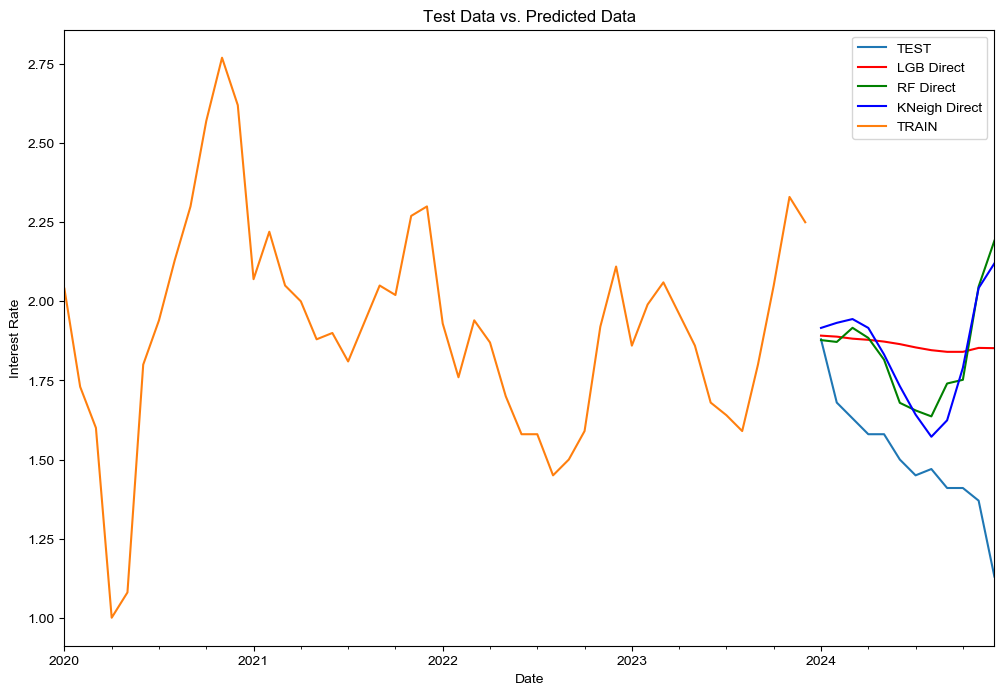

In [ ]:
# Visualize predictions
plt.figure(figsize=(12, 6))
test_data.plot(legend=True, label='TEST', figsize=(12, 8))
multivariate_pred['LGB Direct_predictions'].plot(legend=True, label='LGB Direct', color='red')
multivariate_pred['RF Direct_predictions'].plot(legend=True, label='RF Direct', color='green')
multivariate_pred['KNeigh Direct_predictions'].plot(legend=True, label='KNeigh Direct', color='blue')
train_data.plot(legend=True, label='TRAIN')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('Test Data vs. Predicted Data')
plt.legend()
plt.show()